In [1]:
import json
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
import time
import matplotlib.patches as mpatches

In [2]:
class Object:
    def __init__(self, position, velocity):
        self.position = np.array(position).astype(float)
        self.velocity = np.array(velocity).astype(float)

class MovingObject(Object):
    def __init__(self, position, velocity, acceleration, dt, actor_name):
        super().__init__(position, velocity)
        self.acceleration = np.array(acceleration).astype(float)
        self.dt = float(dt)

    def update(self):
        self.velocity += self.acceleration * self.dt
        self.position += self.velocity * self.dt

class CollisionAnalyzer:
    def __init__(self, object1, object2):
        self.object1 = object1
        self.object2 = object2

    def check_collision(self):
        # Check if the objects are already colliding
        if np.all(self.object1.position == self.object2.position):
            return True

        # Calculate the relative position and velocity of object2 w.r.t. object1
        relative_position = self.object2.position - self.object1.position
        relative_velocity = self.object2.velocity - self.object1.velocity

        # Check if the objects are moving towards each other
        if np.dot(relative_position, relative_velocity) >= 0:
            return False

        # Calculate the time to collision
        time_to_collision = -np.dot(relative_position, relative_velocity) / np.dot(relative_velocity, relative_velocity)

        # Check if the collision will occur within the next time step
        if time_to_collision < 0 or time_to_collision > self.object2.dt:
            return False

        # Calculate the collision point
        collision_point = self.object2.position + self.object2.velocity * time_to_collision

        return True

In [3]:
def Check_file(input_file):
    """Checks whether the input file has any null, none or empty values
    Input: a file path"""
    dir_path = input_file

    for filename in os.listdir(dir_path):
        if filename.endswith('.json'):
            with open(os.path.join(dir_path, filename), 'r') as f:
                data = json.load(f)

            # Loop through all keys in the object and delete any with null, None or empty values
            for key in list(data.keys()):
                if data[key] is None or data[key] == "" or data[key] == "null":
                    del data[key]

            # Write the modified object back to the JSON file
            with open(os.path.join(dir_path, filename), 'w') as f:
                json.dump(data, f, indent=2)

            # Print any keys that were deleted
            deleted_keys = set(data.keys()) - set(json.load(open(os.path.join(dir_path, filename), 'r')).keys())
            if len(deleted_keys) > 0:
                print(f"{filename}: Deleted keys - {deleted_keys}")

In [4]:
def Frames_to_DF(file_path):
    """Converts all frames in a folder into a single dataframe
    Input: a file path"""
    directory = file_path

    dfs = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                captured_objects = data['CapturedObjects']
                df = pd.json_normalize(captured_objects)
                
                # Extract only numbers from the file name
                file_number = re.findall('\d+', filename)[0]
                
                # Add new column with the extracted file number
                df['Frame'] = file_number
                
                dfs.append(df)

    result = pd.concat(dfs, ignore_index=True)
    return result

In [5]:
def Number_object(df):
    """Returns an array of total number of object types caught by sensors from a single dataframe
    input: df(pd.dataframe)"""
    cars = 0
    trucks = 0
    cyclists = 0
    pedestrians = 0
    buses = 0
    motorcycles = 0
    for i in range(len(df)):
        if df.iloc[i]["ObjectType"] == "CAR": 
            cars += 1
        elif df.iloc[i]["ObjectType"] == "TRUCK":
            trucks += 1
        elif df.iloc[i]["ObjectType"] == "BICYCLE":
            cyclists += 1
        elif df.iloc[i]["ObjectType"] == "PEDESTRIAN":
            pedestrians += 1
        elif df.iloc[i]["ObjectType"] == "BUS":
            buses += 1
        elif df.iloc[i]["ObjectType"] == "MOTORCYCLE":
            motorcycles += 1
    objects = np.array([cars, trucks, cyclists, pedestrians, buses, motorcycles])
    return objects

In [6]:
def Average_object(df):
    """returns number of objects captured per frame
    input: df(pd.dataframe)"""
    average = len(df) / len(df['Frame'].unique())
    
    return average

In [7]:
def Scale_data(data, new_max, new_min):
    """Scales data between the desired numbers, inputs in order should be: data(list), new max(int), new min(int)"""
    scaled_data = (data - data.min()) / (data.max() - data.min()) * (new_max - new_min) + new_min
    return scaled_data

In [8]:
def Get_density(df_city, df_highway):
    """Calculates the average number of objects captured in the city and highway
    Input: df_city(pd.dataframe), df_highway(pd.dataframe)"""
    average_city = Average_object(df_city)
    average_highway = Average_object(df_highway)
    
    scaled_city = Scale_data(Number_object(df_city), average_city, 0)
    scaled_highway = Scale_data(Number_object(df_highway), average_highway, 0)
    
    x_labels = ['Car', 'Truck', 'Bicycle', 'Pedestrian', 'Bus', 'Motorcycle']

    # create a stacked bar chart
    fig, ax = plt.subplots()
    ax.bar(x_labels, scaled_city, label=f'City average: {average_city}')
    ax.bar(x_labels, scaled_highway, bottom=scaled_city, label=f'Highway average: {average_highway}')

    # add labels and legend
    ax.set_ylabel('Value')
    ax.set_xlabel('Category')
    ax.set_title('Average density of frames by object type')
    ax.legend()

    plt.show()

In [14]:
def Get_distance(data_frame, frame):
    """Calculates the distance between the car and the objects captured, by dataframe, and returns the average distance
    inputs: data_frame(pd.dataframe), frame(string)"""
    stamp = data_frame[data_frame["Frame"] == frame]
    x_vals = data_frame.loc[data_frame['Frame'] == frame]['BoundingBox3D Origin X'].to_numpy()
    y_vals = data_frame.loc[data_frame['Frame'] == frame]['BoundingBox3D Origin Y'].to_numpy()
    z_vals = data_frame.loc[data_frame['Frame'] == frame]['BoundingBox3D Origin Z'].to_numpy()
    origin = np.array([0, 0, 0])
    distances = np.linalg.norm(np.column_stack((x_vals, y_vals, z_vals)) - origin, axis=1)
    avg_distance = np.mean(distances)
    return avg_distance

In [15]:
def Average_distance(data_frame, interval_start, interval_end):
    """Calculates the average distance of objects from the car through the given interval, interval should be the 
    index of a unique frame, inputs: data_frame(pd.datafarme), interval_start - interval_end(int)"""

    frames = data_frame['Frame'].unique().astype(int)
    sides = []
    for i in range(interval_start, interval_end):
        sides.append(frames[i])
        
    distances = []    
    
    for i in range(len(sides)):
        distances.append(Get_distance(data_frame, str(sides[i])))
        
    avg_distance = np.mean(distances)
        
    fig,ax = plt.subplots(1,1,figsize=(len(sides),6))
    
    ax.plot(distances,'k^', markerfacecolor='w', markersize=12)
    ax.plot([0,len(sides)],[avg_distance,avg_distance], 'r--', label="Average distance from the car in the selected timeframes")
    ax.set_title('Average distance of object from the car per timeframe')
    ax.set_xlabel('Frame number')
    ax.set_ylabel('Avg distance from car ')
    ax.set_xticks(range(len(sides)))
    ax.set_xticklabels(sides)
    plt.legend()
    plt.show()

In [16]:
def Trans_to_local(RT_ECEF_body,frames):
    """Transforms the absolute coordinates of a single object into a local system
    inputs: RT_ECEF_body(transformation matrix), frames(pd.dataframes)"""
    # BoundingBox3D Origin X/Y/Z in the global coordinate system
    global_pos = np.array([frames["BoundingBox3D Origin X"], frames["BoundingBox3D Origin Y"], frames["BoundingBox3D Origin Z"], 1.0])

    # Convert global position to ECEF coordinates
    ecef_pos = np.matmul(RT_ECEF_body, global_pos)

    # Apply transformation matrix to obtain local position
    local_pos = np.matmul(np.linalg.inv(RT_ECEF_body), ecef_pos)

    return local_pos
    

In [17]:
def Get_Collision(data_frame, frame):
    """Using the position and velocity of an object in a single frame,
    checks whether they are going to collide if they would continue moving to the same direction with the same speed,
    and returns the relative time until the collision, inputs: data_frame(pd.dataframe), frame(int)"""
    objects = []
    distances = []
    velocity_magnitudes = []
    time_to_reach = []
    object1 = Object([0, 0, 0], [0, 0, 0])
    
    # Extract data from the dataframe to create the objects realtive to our object 
    for i, row in data_frame[data_frame['Frame'].astype(int) == frame].iterrows():
        object2 = MovingObject([row['local_coordinates'][0], row['local_coordinates'][1], row['local_coordinates'][3]],
                               [row['Relative Velocity X'], row['Relative Velocity Y'], row['Relative Velocity Z']],
                               [row['Relative Acceleration X'], row['Relative Acceleration X'], row['Relative Acceleration Z']],
                               row['time_host'], row['ActorName'])
        objects.append(object2)
        
    # Checking if the object are going to collide
    for i in range(len(objects)):
        velocity_vector = [data_frame['Relative Velocity X'][i],data_frame['Relative Velocity Y'][i],
                           data_frame['Relative Velocity Z'][i]]
        analyzer = CollisionAnalyzer(object1, objects[i])
        if analyzer.check_collision():
            print(f"object {data_frame['ActorName'][i]} " f"Collision at time {i*object2.dt}")
            distances.append(distance.euclidean([0,0,0], [data_frame['local_coordinates'][i][0], 
                                                      data_frame['local_coordinates'][i][1], 
                                                      data_frame['local_coordinates'][i][2]]))
            velocity_magnitudes.append(np.sqrt(sum([v**2 for v in velocity_vector])))
        else:
            distances.append(0)
            velocity_magnitudes.append(0)
            
    # Calculate the time until collsion
    for i in range(len(objects)):
        if velocity_magnitudes[i] == 0:
            # Skip objects with zero velocity magnitude
            time_to_reach.append(0)
        else:
            time_to_reach.append(distances[i]/velocity_magnitudes[i])
    return time_to_reach

In [18]:
def min_max(data):
    """Sclaes the data betwwen 0 and 1, input: data(list)"""
    dataMin = min(data)
    dataMax = max(data)

    dataS = (data-dataMin) / (dataMax-dataMin)
    return dataS

In [19]:
def Get_Objects(frame, rates):
    """Visualizes all objects in the local system, highlights them based on their relevance, 
    where relevance is the likelihood that our object has to change course because of them
    input: frame(int), rates(list)"""
    
    car_pos = [0, 0, 0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(car_pos[0], car_pos[1], car_pos[2], color='blue')
    
    frame_objects = Frames_city[Frames_city["Frame"].astype(int) == frame]
    
    for i in range(len(frame_objects)):
        
        # Define local coordinates of car and captured object
        object_pos = [frame_objects['local_coordinates'][i][0], frame_objects['local_coordinates'][i][1],
                      frame_objects['local_coordinates'][i][2]]
        
        #Relevance is calculated as the inverse of the time of possible collision
        if rates[i] == 0:
            ax.scatter(object_pos[0], object_pos[1], object_pos[2], color='black')
        elif rates[i] >= 0.8:
            ax.scatter(object_pos[0], object_pos[1], object_pos[2], color='yellow')
        elif rates[i] >= 0.6:
            ax.scatter(object_pos[0], object_pos[1], object_pos[2], color='gold')
        elif rates[i] >= 0.4:
            ax.scatter(object_pos[0], object_pos[1], object_pos[2], color='darkorange')
        elif rates[i] >= 0.2:
            ax.scatter(object_pos[0], object_pos[1], object_pos[2], color='tomato')
        elif 0.2 > rates[i] > 0:
            ax.scatter(object_pos[0], object_pos[1], object_pos[2], color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Significance of Objects of frame: {frame}')
    
    # Add manual legend
    legend_patches = [mpatches.Patch(color='black', label='Unsignificant'),
                      mpatches.Patch(color='yellow', label='Mildly significant'),
                      mpatches.Patch(color='gold', label='Moderately significant'),
                      mpatches.Patch(color='darkorange', label='Quite significant'),
                      mpatches.Patch(color='tomato', label='Highly significant'),
                      mpatches.Patch(color='red', label='Extremely significant')]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.7, 1))

    plt.show()

In [15]:
def load_ego(source):
    """Loads the egomotion type json and checks for null/none values, corrupted lines are printed out"""

    # Load the JSON file
    with open(source, 'r') as f:
        data = json.load(f)

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame.from_dict(data, orient='index')

    # Create a new dictionary to store the filtered data
    new_data = {}

    # Loop through each item in the original data
    for key, value in data.items():
        # Check if any value is None, null, or empty
        if any(val is None or val == "" or val == "null" for val in json.dumps(value)):
            print(f"Skipping item {key} as it contains missing values")
        else:
            # Add the item to the new dictionary
            new_data[key] = value

    # Write the filtered data to a new file
    with open('new_data.json', 'w') as f:
        json.dump(new_data, f, indent=2)

    # Print the values that are not written in the new file
    for key, value in data.items():
        if key not in new_data:
            print(f"Item {key} with value {value} is not written in the new file")
    return df

In [16]:
df = load_ego('C:/Users/Aron/Downloads/OneDrive_2023-04-21/Data eval/data/egomotion2.json')

In [17]:
Check_file('C:/Users/Aron/city_json_data')

In [18]:
# This cell can be slow, may need to run twice
Frames_city = Frames_to_DF('C:/Users/Aron/city_json_data/3d_body')
Frames_highway = Frames_to_DF('C:/Users/Aron/highway_json_data/3d_body')

In [20]:
transformation_city = df.loc['33356':'37534', :]
transformation_highway = df.loc['14300':'19857', :]

In [21]:
avg_objects_city = Number_object(Frames_city)
avg_objects_highway = Number_object(Frames_highway)

Text(0.5, 1.0, 'Distribution of objects caught in the frames in the city')

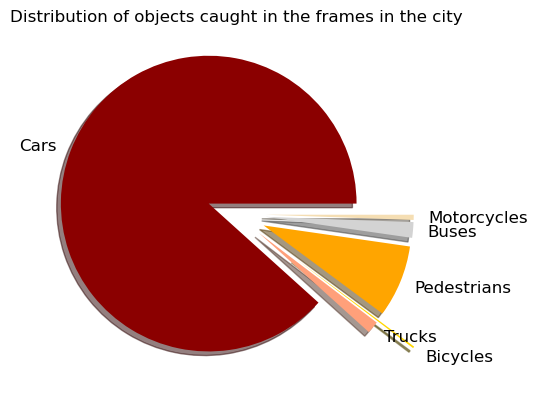

In [22]:
labels = ["Cars", "Trucks", "Bicycles", "Pedestrians", "Buses", "Motorcycles"]
colors = ["darkred", "lightsalmon", "gold", "orange", "lightgrey", "wheat"]

highlighted_slice = 2 
explode = [0.2] * len(labels)
explode[highlighted_slice] = 0.5

plt.pie(avg_objects_city, labels=labels, colors=colors, shadow=True, textprops={'fontsize': 12}, explode=explode)
plt.title("Distribution of objects caught in the frames in the city")

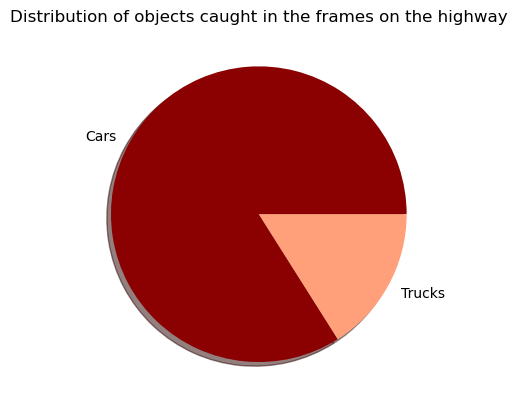

In [23]:
non_zero_sizes = [s for s in avg_objects_highway if s != 0]
non_zero_labels = [labels[i] for i in range(len(avg_objects_highway)) if avg_objects_highway[i] != 0]
plt.pie(non_zero_sizes, labels=non_zero_labels, colors=colors, shadow=True)
plt.title("Distribution of objects caught in the frames on the highway")
plt.show()

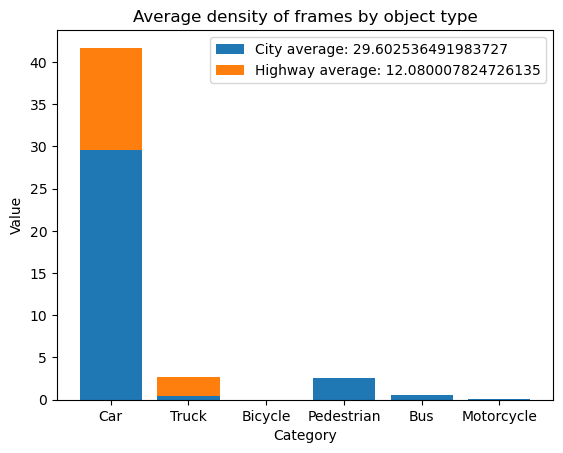

In [24]:
Get_density(Frames_city, Frames_highway)

In [25]:
Frames_city['local_coordinates'] = pd.Series(dtype=float, index=Frames_city.index)
Frames_highway['local_coordinates'] = pd.Series(dtype=float, index=Frames_highway.index)

In [26]:
# Convert the Frame column to a string data type
Frames_city['Frame'] = Frames_city['Frame'].astype(str)

# Remove the first two characters from each string in the Frame column
Frames_city['Frame'] = Frames_city['Frame'].str[2:]

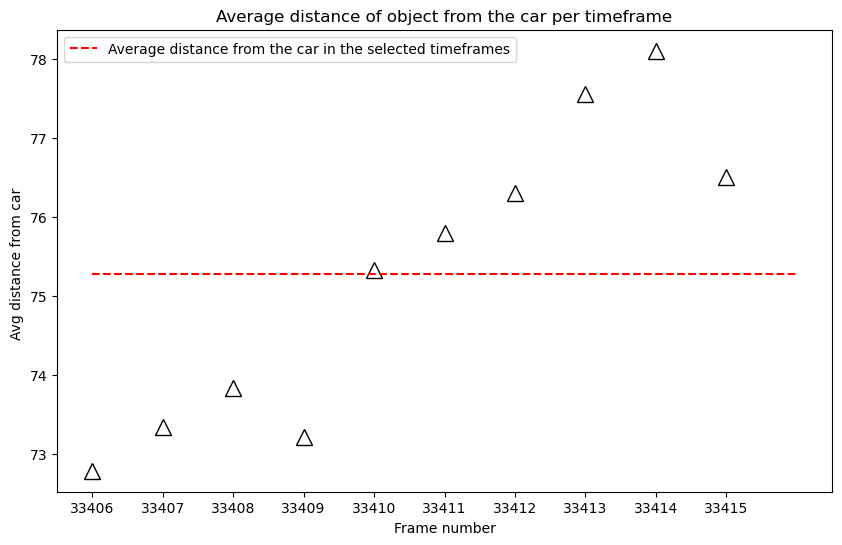

In [27]:
Average_distance(Frames_city, 50, 60)

In [41]:
Frames_city = pd.merge(Frames_city, transformation_city, left_on='Frame', right_index=True)
Frames_highway = pd.merge(Frames_highway, transformation_highway, left_on='Frame', right_index=True)

In [42]:
local_coordinates = []

for index, row in Frames_city.iterrows():
    local_coord = Trans_to_local(row['RT_ECEF_body'], row)
    local_coordinates.append(local_coord)

Frames_city['local_coordinates'] = local_coordinates

In [34]:
arr = Get_Collision(Frames_city, 33356)
print(arr)

object CAR 00 Collision at time 0.0
object CAR 04 Collision at time 5028123166.150162
object CAR 06 Collision at time 8380205276.916935
object CAR 07 Collision at time 10056246332.300323
object CAR 08 Collision at time 11732287387.68371
object PEDESTRIAN 09 Collision at time 13408328443.067097
object CAR 10 Collision at time 15084369498.450483
object PEDESTRIAN 11 Collision at time 16760410553.83387
object CAR 12 Collision at time 18436451609.21726
object CAR 13 Collision at time 20112492664.600647
object CAR 14 Collision at time 21788533719.98403
object PEDESTRIAN 15 Collision at time 23464574775.36742
object CAR 21 Collision at time 31844780052.284355
object CAR 22 Collision at time 33520821107.66774
object CAR 25 Collision at time 35196862163.05113
object CAR 29 Collision at time 38548944273.8179
object CAR 30 Collision at time 40224985329.201294
object PEDESTRIAN 34 Collision at time 43577067439.96806
object CAR 36 Collision at time 45253108495.35145
[1.36282148646211, 0, 0, 0.8249

In [35]:
rates = min_max(np.array(arr))

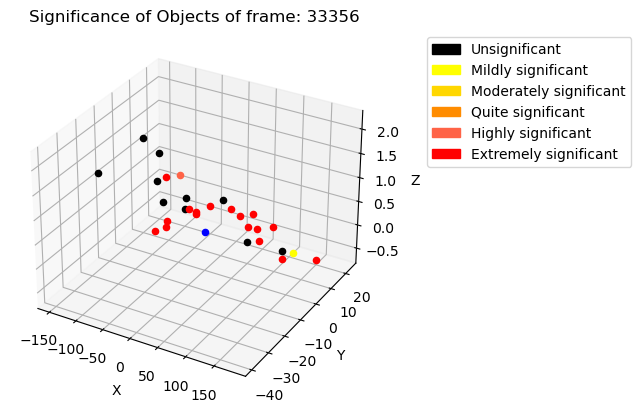

In [36]:
Get_Objects(33356, rates)